In [1]:
!pip install einops
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torchvision import transforms
from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler
from tqdm import tqdm
import numpy as np
import torch.utils.data as data
import matplotlib.pyplot as plt
from torch.optim import Optimizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 4.4 MB/s eta 0:00:00


In [2]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

In [3]:
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

In [4]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

In [5]:
class ViT(nn.Module):   
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [6]:
class CIFAR10_truncated(data.Dataset):
    def __init__(self, root, dataidxs=None, train=True, transform=None, target_transform=None, download=True):
        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download
        self.data, self.target = self.build_truncated_dataset()
    
    def build_truncated_dataset(self):
        cifar_dataobj = dset.CIFAR10(self.root, self.train, self.transform, self.target_transform, self.download)
        data = np.array(cifar_dataobj.data)
        target = np.array(cifar_dataobj.targets)
        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]
        
        return data, target
    
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)

In [7]:
class Scheduler(_LRScheduler):
    def __init__(self, 
                 optimizer: Optimizer,
                 dim_embed: int,
                 warmup_steps: int,
                 last_epoch: int=-1,
                 verbose: bool=False) -> None:

        self.dim_embed = dim_embed
        self.warmup_steps = warmup_steps
        self.num_param_groups = len(optimizer.param_groups)

        super().__init__(optimizer, last_epoch, verbose)
        
    def get_lr(self) -> float:
        lr = calc_lr(self._step_count, self.dim_embed, self.warmup_steps)
        return [lr] * self.num_param_groups


def calc_lr(step, dim_embed, warmup_steps):
    return dim_embed**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))

In [8]:
batch_size = 128
img_size = 32
# load the index of imbalanced CIFAR-10 from dataidx.txt

transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = CIFAR10_truncated(root='./cifar10', train=True, 
                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)

transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

testset = CIFAR10_truncated(root='./cifar10', train=False, 
                    download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

classes = ['plane', 'car', 'bird', 'cat',
        'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using', device)
criterion = nn.CrossEntropyLoss(label_smoothing = 0.1)     #label smoothing
model = ViT(image_size=32, patch_size=4, num_classes=10, dim=1024, depth=12,
            heads=8, mlp_dim=2048, dropout=0.1, emb_dropout=0.1).to(device) #residual dropout 0.1

resume = False
if resume:
    load_path = './cifar_vit_best.pth'
    model.load_state_dict(torch.load(load_path))
epochs = 15
#optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
optimizer = optim.Adam(model.parameters(),lr=0.001,betas=(0.9, 0.999), eps=1e-7)
scheduler = Scheduler(optimizer,1024,300)


model.to(device)
save_path = './cifar_vit_best.pth'
best_acc = 0.0
loss_plot = []
acc_plot = []
for epoch in range(epochs):  

    running_loss = 0.0
    model.train()
    for i, data in enumerate(tqdm(trainloader), 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    tqdm.write('Loss of epoch {}: {:.3f}'.format(epoch + 1, running_loss / (i + 1)))
    loss_plot.append(running_loss / (i + 1))
    
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = 100 * correct / total
        tqdm.write('Testing Accuracy: {:.2f}'.format(acc))
        acc_plot.append(acc)
        if acc > best_acc:
            tqdm.write('Model saved.')
            torch.save(model.state_dict(), save_path)
            best_acc = acc
    scheduler.step()
print('Finished Training')
print(loss_plot)
print(acc_plot)


100%|██████████| 170498071/170498071 [00:05<00:00, 29569766.84it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Using cuda


100%|██████████| 391/391 [07:12<00:00,  1.11s/it]

Loss of epoch 1: 2.082


Testing Accuracy: 32.79
Model saved.


100%|██████████| 391/391 [07:17<00:00,  1.12s/it]

Loss of epoch 2: 1.886


Testing Accuracy: 43.60
Model saved.


100%|██████████| 391/391 [07:18<00:00,  1.12s/it]

Loss of epoch 3: 1.723


Testing Accuracy: 50.80
Model saved.


100%|██████████| 391/391 [07:18<00:00,  1.12s/it]

Loss of epoch 4: 1.622


Testing Accuracy: 54.17
Model saved.


100%|██████████| 391/391 [07:18<00:00,  1.12s/it]

Loss of epoch 5: 1.547


Testing Accuracy: 57.68
Model saved.


100%|██████████| 391/391 [07:18<00:00,  1.12s/it]

Loss of epoch 6: 1.483


Testing Accuracy: 59.15
Model saved.


100%|██████████| 391/391 [07:18<00:00,  1.12s/it]

Loss of epoch 7: 1.443


Testing Accuracy: 60.93
Model saved.


100%|██████████| 391/391 [07:18<00:00,  1.12s/it]

Loss of epoch 8: 1.402


Testing Accuracy: 62.22
Model saved.


100%|██████████| 391/391 [07:18<00:00,  1.12s/it]

Loss of epoch 9: 1.364


Testing Accuracy: 63.57
Model saved.


100%|██████████| 391/391 [07:18<00:00,  1.12s/it]

Loss of epoch 10: 1.331


Testing Accuracy: 64.73
Model saved.


100%|██████████| 391/391 [07:18<00:00,  1.12s/it]

Loss of epoch 11: 1.298


Testing Accuracy: 66.56
Model saved.


100%|██████████| 391/391 [07:18<00:00,  1.12s/it]

Loss of epoch 12: 1.266


Testing Accuracy: 66.42


100%|██████████| 391/391 [07:18<00:00,  1.12s/it]

Loss of epoch 13: 1.239


Testing Accuracy: 68.63
Model saved.


100%|██████████| 391/391 [07:18<00:00,  1.12s/it]

Loss of epoch 14: 1.212


Testing Accuracy: 68.35


100%|██████████| 391/391 [07:17<00:00,  1.12s/it]

Loss of epoch 15: 1.192


Testing Accuracy: 69.21
Model saved.
Finished Training
[2.0821559837712047, 1.8864812811317346, 1.7227664826166293, 1.6224887182035714, 1.546805416226692, 1.4830653005853638, 1.4433918825500762, 1.4015126767975594, 1.3638575436818936, 1.3313003589430124, 1.2980769208020262, 1.2657876374471524, 1.2392618195784977, 1.211613156301591, 1.1917991680867226]
[32.79, 43.6, 50.8, 54.17, 57.68, 59.15, 60.93, 62.22, 63.57, 64.73, 66.56, 66.42, 68.63, 68.35, 69.21]


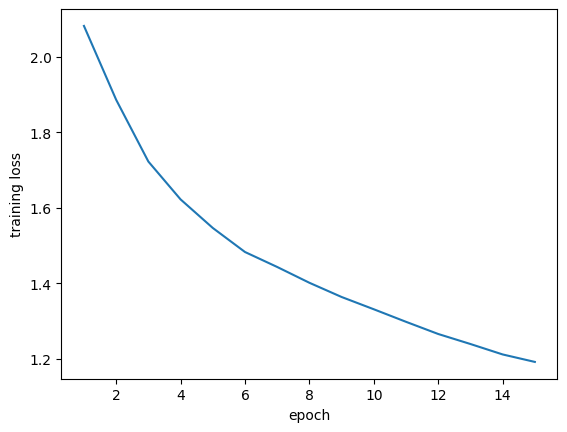

In [9]:
x1 = list(x+1 for x in range(15))
y1 = loss_plot
plt.xlabel('epoch') 
plt.ylabel('training loss') 
plt.plot(x1,y1)

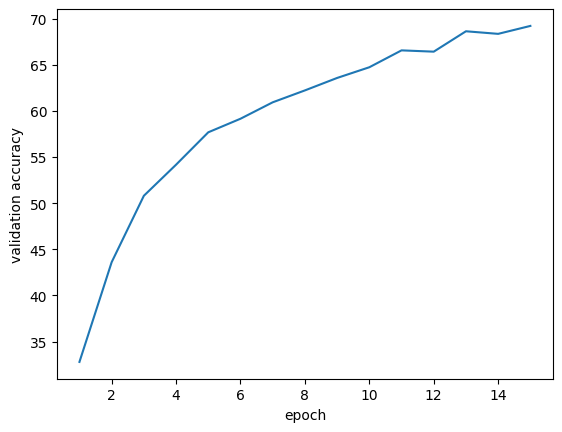

In [10]:
y2 = acc_plot
plt.xlabel('epoch') 
plt.ylabel('validation accuracy') 
plt.plot(x1,y2)